In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision.models import segmentation
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import utils
import importlib
import plots
import seaborn as sns
import time
import pandas as pd
import tikzplotlib
import matplotlib.patches as mpatches
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast


## Loading the data

In [2]:
DEVICE = torch.device("cuda")  

# Split the data to train-, val- and testloaders 
trainloader, valloader, testloader = utils.load_datasets_centralized(test_size=0.2, val_size=0.2, batch_size=8, path='data')

## Testing the models

In [3]:
models = {'deeplabv3_mobilenet_v3_large': segmentation.deeplabv3_mobilenet_v3_large(num_classes=3).to(DEVICE),
          'deeplabv3_resnet101': segmentation.deeplabv3_resnet101(num_classes=3).to(DEVICE),
          'deeplabv3_resnet50': segmentation.deeplabv3_resnet50(num_classes=3).to(DEVICE),
         'fcn_resnet50': segmentation.fcn_resnet50(num_classes=3).to(DEVICE),
          'fcn_resnet101': segmentation.fcn_resnet101(num_classes=3).to(DEVICE),
          'lraspp_mobilenet_v3_large': segmentation.lraspp_mobilenet_v3_large(num_classes=3).to(DEVICE),
          }

# Training with early stopping.

In [ ]:
importlib.reload(utils)
results = utils.train_early_stopping(models['lraspp_mobilenet_v3_large'], trainloader, testloader, valloader, epochs=30, device=DEVICE, patience=5)

sns.set_theme()

plt.rc('axes', labelsize=14) 
plt.rc('xtick', labelsize=12)  
plt.rc('ytick', labelsize=12) 
style = ['-', '--', ':']
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
x = list(range(1, len(results['Loss']) + 1))
y = results['Loss']
ax[0].plot(x, y)
ax[0].set_ylabel('Loss', fontsize=16)
ax[0].set_xlabel('Epoch', fontsize=16)

for i, metric in enumerate(['IoU', 'Accuracy', 'F-score']):
    x = list(range(1, len(results[metric]) + 1))
    y = results[metric]
    ax[1].plot(x, y, label=metric, linestyle=style[i])
    
ax[0].set_xticks(range(0,len(x),2)) 
ax[1].set_xticks(range(0,len(x),2)) 
ax[1].set_ylabel('Score', fontsize=16)
ax[1].set_xlabel('Epoch', fontsize=16)
ax[1].legend()

plt.tight_layout()
plt.show()


# Create Dataset Plot

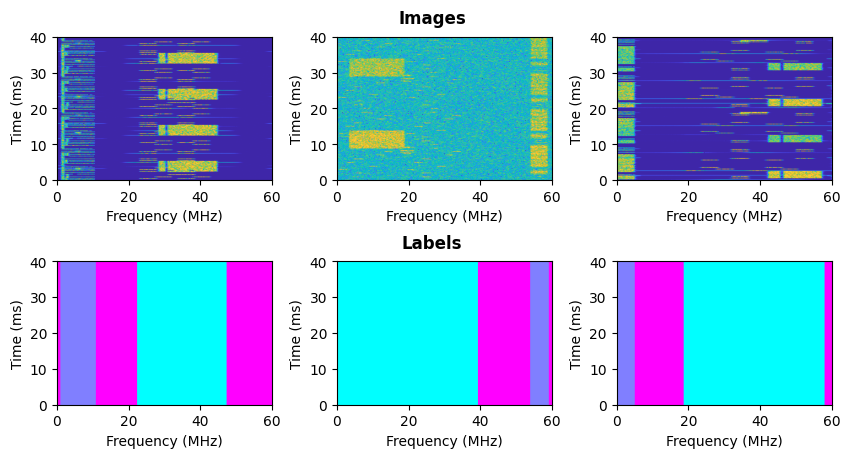

In [14]:
importlib.reload(plots)

def create_dataset_plot(dataloader, figsize_x, figsize_y):
    """
    Creates 3 random images of the dataset.
    """

    colors = plt.get_cmap('cool')(np.linspace(0, 1, 3))
    classes = ['5G', 'LTE', 'Noise']

    patches = [mpatches.Patch(color=colors[i], label=classes[i]) for i in range(len(classes))]

    images, labels = next(iter(dataloader))
    denormalized_images = images.permute(0, 2, 3, 1).numpy() / 2 + 0.5
    ground_truth_labels = labels.cpu().numpy()
    fig, axes = plt.subplots(2, 3, figsize=(figsize_x, figsize_y))
    plt.style.use('default')

    for i in range(3):
        random_index = np.random.randint(0, images.shape[0])
        ground_truth_label = ground_truth_labels[random_index]
        image = np.int64(denormalized_images[random_index])

        axes[0, i].imshow(image, extent=[0, 60, 0, 40])
        axes[0, i].set_xlabel('Frequency (MHz)')
        axes[0, i].set_ylabel('Time (ms)')

        im = axes[1, i].imshow(ground_truth_label, cmap='cool', extent=[0, 60, 0, 40])
        axes[1, i].set_xlabel('Frequency (MHz)')
        axes[1, i].set_ylabel('Time (ms)')

    fig.text(0.5, 0.9, 'Images', ha='center', va='center', fontsize=12, weight='bold')
    fig.text(0.5, 0.45, 'Labels', ha='center', va='center', fontsize=12, weight='bold')
    fig.subplots_adjust(wspace=0.3, hspace=0.4, right=0.9)
    tikzplotlib.save("my_tikz.tex")

    plt.show()



create_dataset_plot(trainloader, 10, 5)

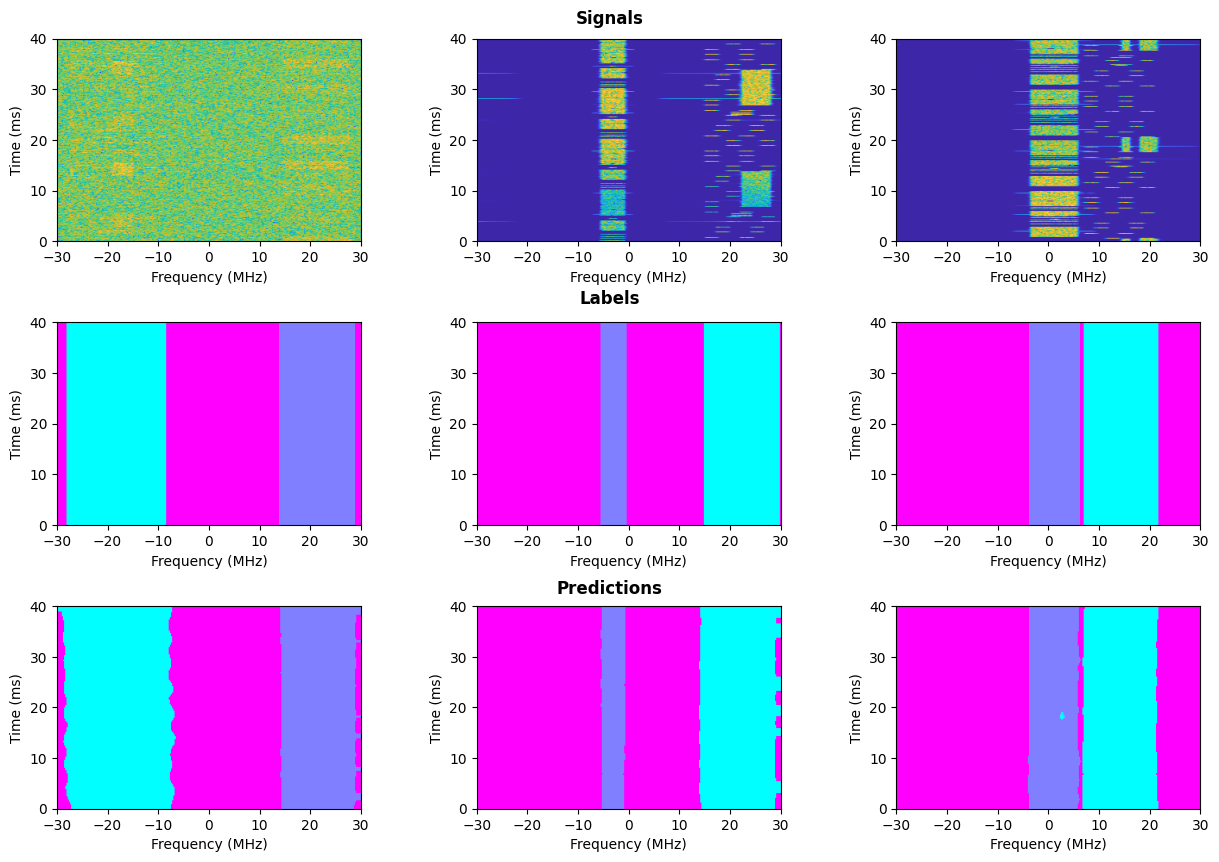

In [73]:
def plot_predictions(net, dataloader, figsize_x, figsize_y, device):
    colors = plt.get_cmap('cool')(np.linspace(0, 1, 3))
    classes = ['5G', 'LTE', 'Noise']
    patches = [mpatches.Patch(color=colors[i], label=classes[i]) for i in range(len(classes))]

    net.eval()  
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    outputs = net(images)["out"]
    _, preds = torch.max(outputs, 1) 
    images = images.cpu().permute(0, 2, 3, 1).numpy()/2+ 0.5
    labels = labels.cpu().numpy()
    preds = preds.cpu().numpy()

    fig, axes = plt.subplots(3, 3, figsize=(figsize_x, figsize_y))
    plt.style.use('default')

    for i in range(3):
        image = np.int64(images[i])
        ground_truth_label = labels[i]
        pred = preds[i]
        axes[0, i].imshow(image, extent=[-30, 30, 0, 40])
        axes[0, i].set_xlabel('Frequency (MHz)')
        axes[0, i].set_ylabel('Time (ms)')
        axes[1, i].imshow(ground_truth_label, cmap='cool', extent=[-30, 30, 0, 40])
        axes[1, i].set_xlabel('Frequency (MHz)')
        axes[1, i].set_ylabel('Time (ms)')
        axes[2, i].imshow(pred, cmap='cool', extent=[-30, 30, 0, 40])
        axes[2, i].set_xlabel('Frequency (MHz)')
        axes[2, i].set_ylabel('Time (ms)')

    fig.text(0.5, 0.9, 'Signals', ha='center', va='center', fontsize=12, weight='bold')
    fig.text(0.5, 0.62, 'Labels', ha='center', va='center', fontsize=12, weight='bold')
    fig.text(0.5, 0.33, 'Predictions', ha='center', va='center', fontsize=12, weight='bold')
    fig.subplots_adjust(wspace=0.3, hspace=0.4, right=0.9)
    tikzplotlib.save('prediction.tex')
    plt.show()


plot_predictions(models['lraspp_mobilenet_v3_large'], testloader, 15, 10, DEVICE)

In [ ]:
importlib.reload(plots)

HE = utils.create_context()

flat_params = {}
for name, model in models.items():
    ndarrays = utils.get_parameters(model)
    flat_param, _ = utils.flatten_parameters(ndarrays)
    flat_params[name] = flat_param


encryption_times = []
for name, flat_params in flat_params.items():
    start_time = time.time()
    encrypted_model = utils.encrypt(flat_params, HE)
    end_time = time.time()

    encryption_time = end_time - start_time
    encryption_times.append(encryption_time)

# Find Encryption Time

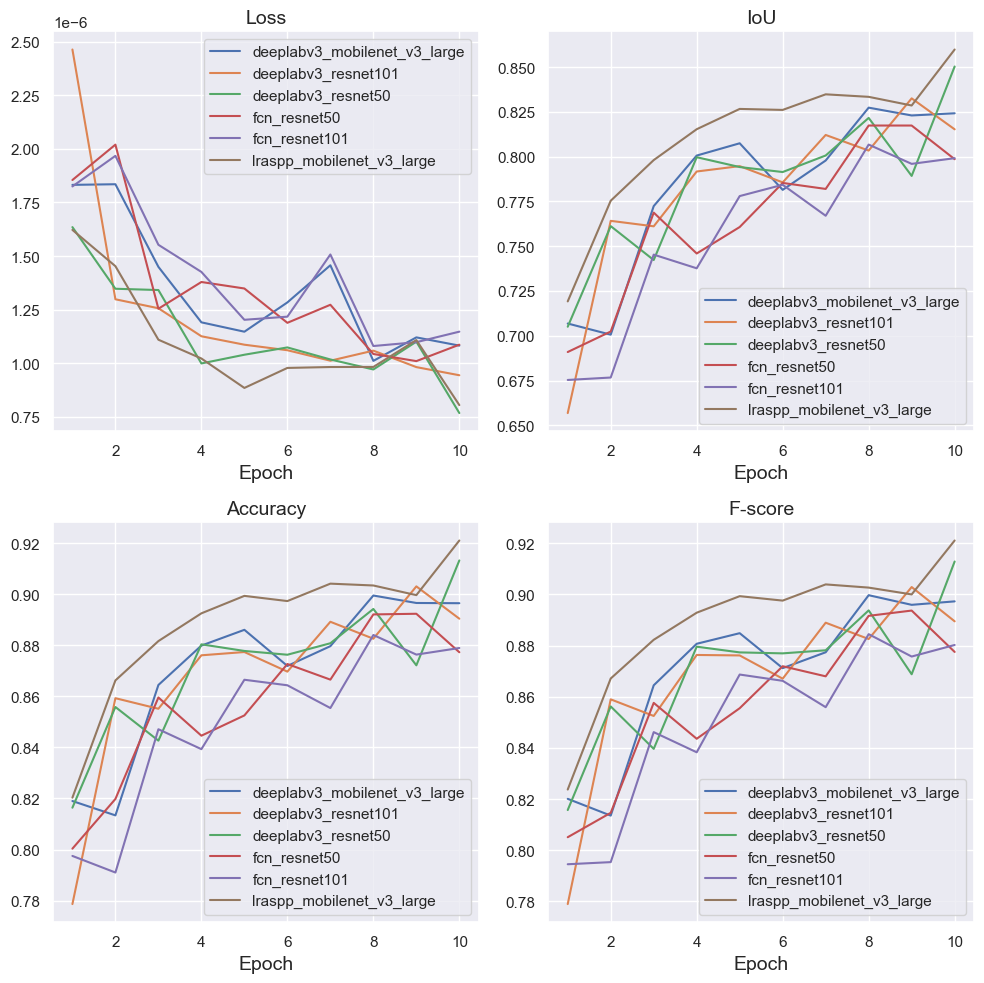

In [ ]:
df = pd.read_csv("model_results.csv")

df['Loss'] = df['Loss'].apply(lambda x: [float(i) for i in x.strip('[]').split(', ')])
df['IoU'] = df['IoU'].apply(lambda x: [float(i) for i in x.strip('[]').split(', ')])
df['Accuracy'] = df['Accuracy'].apply(lambda x: [float(i) for i in x.strip('[]').split(', ')])
df['F-score'] = df['F-score'].apply(lambda x: [float(i) for i in x.strip('[]').split(', ')])

df_long = pd.DataFrame()
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

metrics = ['Loss', 'IoU', 'Accuracy', 'F-score']
for i, ax in enumerate(axs.flatten()):
    metric = metrics[i]
    for model in df['Model'].unique():
        ax.plot(range(1, len(df[df['Model'] == model][metric].values[0]) + 1), df[df['Model'] == model][metric].values[0], label=model)
        ax.set_title(metric, fontsize=14)
        ax.set_xlabel('Epoch', fontsize=14)
        ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
df = pd.read_csv('results/data/model_results.csv',index_col=0)
for column in df.columns:
    df[column] = df[column].apply(ast.literal_eval)
df

,Loss,IoU,Accuracy,F-score
Model,,,,
deeplabv3_mobilenet_v3_large,"[1.8321638309417824e-06, 1.8350683692208096e-0...","[0.7068281185013753, 0.7005935711020448, 0.772...","[0.8189872741699219, 0.8133721245659722, 0.864...","[0.8200735039568902, 0.8135165605806781, 0.864..."
deeplabv3_resnet101,"[2.4633976029993693e-06, 1.2985580193950833e-0...","[0.6568124664594502, 0.7641631205034809, 0.761...","[0.7786324395073785, 0.8592667473687066, 0.855...","[0.7789289019773568, 0.8589731746948819, 0.852..."
deeplabv3_resnet50,"[1.6350572877854574e-06, 1.347636459867216e-06...","[0.7050314571875161, 0.7612199869185077, 0.742...","[0.8163772583007812, 0.8558146158854166, 0.842...","[0.8156911884009044, 0.8562015748085663, 0.839..."
fcn_resnet50,"[1.8547931997798313e-06, 2.019720260351379e-06...","[0.6909090620600428, 0.7023598479854369, 0.768...","[0.8003367106119792, 0.8197941250271268, 0.859...","[0.80507018789059, 0.8146059600519931, 0.85759..."
fcn_resnet101,"[1.8248117385155639e-06, 1.9675255316542463e-0...","[0.675304061136709, 0.6766648114753382, 0.7453...","[0.7974856906467014, 0.7909887525770399, 0.847...","[0.7944986932653328, 0.7953304274729108, 0.846..."
lraspp_mobilenet_v3_large,"[1.622111959578534e-06, 1.4529101071679584e-06...","[0.719181852111369, 0.7753955522943078, 0.7980...","[0.8203082614474826, 0.866224839952257, 0.8816...","[0.8237091937633644, 0.8671219562917797, 0.882..."
